<a href="https://colab.research.google.com/github/dcolinmorgan/test/blob/master/LTCOPD_TS_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LTCOPD dataset analyzed for time series prediction

In [ ]:
!pip install GEOparse

In [1]:
import os
# import s3fs
import pandas as pd
import numpy as np
from psutil import *
import matplotlib.pyplot as plt
import gc
from scipy import stats
import seaborn as sns
from scipy.stats import zscore
import tensorflow as tf


# Parse Data

In [ ]:
import GEOparse
gse = GEOparse.get_GEO(geo="GSE76925", destdir="./")

In [ ]:
gpl = gse.gpls[next(iter(gse.gpls))]
data = gse.pivot_samples(values="VALUE")#, gpl=gpl, annotation_column="Symbol")
data.sort_index
pheno=gse.phenotype_data.rename(columns={'characteristics_ch1.0.age': 'age',"characteristics_ch1.1.Sex":"sex","characteristics_ch1.3.bmi":"bmi","characteristics_ch1.6.fev1.pp":"fev1","characteristics_ch1.4.packyears":"PY"})
pheno[['age',"sex","bmi","fev1","PY"]].to_csv('pheno_data.txt',sep='\t',index=True,header=True)

In [ ]:
ALL=data.merge(illumina_labels,left_index=True,right_index=True)
ALL.index=ALL['symbol']
# FEMALE=FEMALE[FEMALE['loc']!='Y']
del ALL['symbol'], ALL['loc']
ALL.columns=[np.round(gse.phenotype_data['characteristics_ch1.0.age'].astype('float'),0).astype('object').astype(str)]
ALL=ALL.groupby(by=ALL.columns, axis=1).median()

ALL.columns=[42, 44, 48, 50, 52, 53,54, 55, 56, 57, 58, 59,60, 61, 62, 63, 64, 65,66, 67, 68, 69, 70, 71,72, 73, 74, 75, 76, 77,78, 82, 84, 86]

ALL[49]=np.nan
ALL[51]=np.nan

# ALL[79]=np.nan
# ALL[80]=np.nan
# ALL[81]=np.nan
# ALL[83]=np.nan
# ALL[85]=np.nan
# ALL = ALL.reindex(sorted(ALL.columns), axis=1)
ALL = ALL.reindex(sorted(ALL.columns,reverse=True), axis=1) ##reverse order to predict younger expression


In [ ]:
data.to_csv('drive/My Drive/Colab Notebooks/GSE76925.txt',sep='\t')
pheno.to_csv('drive/My Drive/Colab Notebooks/GSE76925_pheno.txt',sep='\t')
ALL.to_csv('drive/My Drive/Colab Notebooks/GSE76925_merged.txt',sep='\t')

In [ ]:
def plot_series(time, series, jj,format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(jj)
    plt.grid(True)
    plt.savefig(('drive/My Drive/'+jj+'.png'))

# def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
#   series = tf.expand_dims(series, axis=-1)
#   dataset = tf.data.Dataset.from_tensor_slices(series)
#   dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
#   dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
#   dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
#   dataset = dataset.batch(batch_size).prefetch(1)
#   return dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

# Read Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')
illumina_labels=pd.read_csv('drive/My Drive/Colab Notebooks dcm/GPL10558_illumina_prb_loc.txt',sep='\t',index_col=0,header=None,names=['loc','symbol'])
data=pd.read_csv('drive/My Drive/Colab Notebooks/GSE76925.txt',sep='\t',index_col=0)#,header=None,names=['age',"sex","bmi","fev1","PY"])
pheno=pd.read_csv('drive/My Drive/Colab Notebooks/GSE76925_pheno.txt',sep='\t')
ALL=pd.read_csv('drive/My Drive/Colab Notebooks/GSE76925_merged.txt',sep='\t',index_col=0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
tdata=pd.DataFrame(ALL.T, index=ALL.columns)#.interpolate(method='time')
tdata['Datetime'] = pd.to_datetime('19'+(ALL.columns.astype(str)) + ' ' +'10:00:00 ')
tdata = tdata.set_index('Datetime')
# ALL.iloc[1,:].to_list()#.dropna(how='any')
tdata=tdata.interpolate(method='time')
# ttdata=tdata.T ## had transposed it before latest attempt at multi-LSTM training


# ALL#[:split_time].tolist().strip('F')
# FEMALE.columns=[42, 48, 50, 52, 53, 54,55, 56, 57, 58, 59, 60,61, 62, 63, 64, 65, 66,67, 68, 69, 70, 71, 72,73, 74, 75, 76, 77, 78,82, 84, 86]
# time=[42, 48, 50, 52, 53, 54,55, 56, 57, 58, 59, 60,61, 62, 63, 64, 65, 66,67, 68, 69, 70, 71, 72,73, 74, 75, 76, 77, 78,82, 84, 86]

# Format Data

In [ ]:
split_time = 30
heat=pd.DataFrame()
window_size = 6
batch_size = 10
shuffle_buffer_size = 10

i=int(np.random.randint(1, high=ttdata.shape[0], size=1) )
series=np.array(ttdata.iloc[i,:])

time_train = ALL.columns[:split_time]
x_train = series[:split_time]
time_valid = ALL.columns[split_time:]
x_valid = series[split_time:]
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


In [ ]:
# tf.keras.backend.clear_session()
# # tf.random.set_seed(51)
# # np.random.seed(51)

# # window_size = 30
# train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Conv1D(filters=32, kernel_size=5,
#                       strides=1, padding="causal",
#                       activation="relu",
#                       input_shape=[None, 1]),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
#   tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 200)
# ])
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20))
# optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
# model.compile(loss=tf.keras.losses.Huber(),
#               optimizer=optimizer,
#               metrics=["mae"])
# history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

## indv gene

In [ ]:
tf.keras.backend.clear_session()
# tf.random.set_seed(51)
# np.random.seed(51)
# window_size = 64
# batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(18, return_sequences=True),
  tf.keras.layers.LSTM(18, return_sequences=True),
  tf.keras.layers.Dense(12, activation="relu"),
  tf.keras.layers.Dense(9, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule],verbose=1)


(1e-08, 0.0001, 0.0, 30.0)

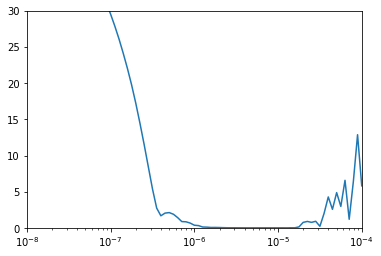

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

# First Model

In [ ]:
# # split_time = 35
# # heat=pd.DataFrame()
# # window_size = 5
# # batch_size = 5
# # shuffle_buffer_size = 1000

# ###RNN
# # model = tf.keras.models.Sequential([
# #   tf.keras.layers.Dense(128, activation="relu", input_shape=[window_size]),
# #   tf.keras.layers.Dropout(0.1),
# #   tf.keras.layers.Dense(128, activation="relu"),
# #   tf.keras.layers.Dropout(0.1),
# #   tf.keras.layers.Dense(1),#,activation="sigmoid"),
# # ])
# # lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     # lambda epoch: 1e-8 * 10**(epoch / 20))
# # optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
# # model.compile(metrics="mse", loss=tf.keras.losses.Huber(), ##less sensitive to outliers
# #               optimizer=optimizer)
# tf.keras.backend.clear_session()
# ###LSTM
# # model = tf.keras.models.Sequential([
# #   # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
# #   #                     input_shape=[None]),
# ###added conv1d
# #   tf.keras.layers.Conv1D(filters=128, kernel_size=3,
# #                       strides=1, padding="causal",
# #                       activation="relu",
# #                       input_shape=[None, 1]),
# #   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
# #   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
# #   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
# #   tf.keras.layers.Dense(1),
# #   tf.keras.layers.Lambda(lambda x: x * 100.0)
# # ])

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Conv1D(filters=10, kernel_size=5,
#                       strides=1, padding="causal",
#                       activation="relu",
#                       input_shape=[None, 1]),
#   tf.keras.layers.LSTM(18, return_sequences=True),
#   # tf.keras.layers.LSTM(18, return_sequences=True),
#   tf.keras.layers.Dense(12, activation="relu"),
#   tf.keras.layers.Dense(9, activation="relu"),
#   tf.keras.layers.Dense(1)
# ])

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20),)
# optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
# model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mae"])

# # model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
# # model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
# j=int(np.random.randint(1, high=ttdata.shape[0], size=1) )

# for i in range(j,j+100):  ##per gene
#   series=np.array(ttdata.iloc[i,:])

#   time_train = ALL.columns[:split_time]
#   x_train = series[:split_time]
#   time_valid = ALL.columns[split_time:]
#   x_valid = series[split_time:]
#   dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

#   history = model.fit(dataset, epochs=500, verbose=0)
  
# ### do prediction and compare to hold out data, or also predict into future/past
#   # loss = history.history['loss']
#   # epochs = range(len(loss))
#   # forecast = []
# ###need to figure out how to get more prediction out of this by changing dimensions somewhere
#   rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
#   rnn_forecast = rnn_forecast[split_time - window_size:-1, -1,0] 

# ###RNN forecasting
#   # history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])
#   # history = model.fit(dataset, epochs=100,  verbose=0,callbacks=[lr_schedule])
#   # for time in range(len(series) - window_size):
#   #   forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
#   # forecast = forecast[split_time-window_size:]
#   # results = np.array(forecast)[:, 0, 0]
#   # cc=tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

# ###predicts new time points not held out or trained on  
#   # model.predict(series[36:30][np.newaxis])


#   cc=tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()
#   if cc<.5:
#     plt.figure(figsize=(10, 6))
#     jj='MAE for '+str(ttdata.index[i])+ ' is '+str(cc)
#     print(jj)
#     plot_series(np.append(time_train,time_valid), np.append(x_train,x_valid),jj)
#     plot_series(time_valid, rnn_forecast,jj) #results)
#     predicted_value = model.predict(series)
#   else:
#     print('MAE for '+str(ttdata.index[i])+ ' is '+str(cc))
#   Col1=ttdata.index[i]
#   Col2=cc
#   column = [Col1, Col2]
#   column=np.transpose(pd.DataFrame((column)))
#   column.to_csv('drive/My Drive/Colab Notebooks dcm/LTCOPD_LSTM_pred40-45.txt',mode='a',header=False,index=False)
#   heat=pd.concat([heat,column],axis=0)

In [ ]:
# tf.keras.backend.clear_session()
# from keras.callbacks import EarlyStopping, LearningRateScheduler,ModelCheckpoint, ReduceLROnPlateau


# model = tf.keras.models.Sequential([
#   tf.keras.layers.Conv1D(filters=32, kernel_size=5,
#                       strides=1, padding="causal",
#                       activation="relu",
#                       input_shape=[None, len(train_y[0])]),
#   tf.keras.layers.LSTM(64, return_sequences=True),
#   tf.keras.layers.LSTM(64, return_sequences=True),
#   tf.keras.layers.Dense(30, activation="relu"),
#   tf.keras.layers.Dense(10, activation="relu"),
#   tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 400)
# ])

# callbacks = [
#     LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20)),
#     EarlyStopping(patience=10, verbose=1),
#     ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
#     ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=False)
# ]

# optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
# model.compile(loss=tf.keras.losses.Huber(),
#               optimizer=optimizer,
#               metrics=["mae"])
# # history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])
# history =model.fit_generator(training_sequence, epochs=100, callbacks=callbacks,validation_data=validation_sequence)



# Predict youth

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.offsets import DateOffset

In [ ]:
train = tdata
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
n_input = 5
generator = TimeseriesGenerator(train,train,sampling_rate=1, length=n_input, batch_size=6)

# train_x=train[0:2999]
# train_y=train[3000:5999]
train_x=train[-30:]
train_y=train[:-30]


n_features = (train_y.shape)

training_sequence = TimeseriesGenerator(train_x, train_x,sampling_rate=1, length=n_input, batch_size=6)
validation_sequence = TimeseriesGenerator(train_y, train_y,sampling_rate=1, stride=12, length=n_input, batch_size=6)

In [ ]:
from keras.callbacks import EarlyStopping, LearningRateScheduler,ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20)),
    EarlyStopping(patience=3, verbose=1),#monitor='loss'),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=False)
]

In [ ]:
import keras
from keras import Sequential
from keras.layers import Dense, LSTM, Conv1D, Bidirectional, Lambda,Dropout
# s = (len(training_sequence.data[0]), len(training_sequence.data[1]))
# s=(train_y.shape[0],train_y.shape[1],)
# model = Sequential()
# # model.add(Conv1D(filters=32, kernel_size=5,strides=1, padding="causal",
# #                  activation="relu",input_shape=[n_input, n_features])),
# model.add(LSTM(4, activation='relu',return_sequences=True, input_shape=s))
# # model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
# model.add(Bidirectional(LSTM(4, return_sequences=True,activation='relu'))),
# # model.add(LSTM(50)),
# model.add(Dropout(0.15)),
# model.add(Dense(1))
# optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
# model.compile(loss='tf.keras.losses.Huber()',optimizer=optimizer,metrics=["mae"])
# optimizer = keras.optimizers.Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='mse',metrics=[['accuracy', 'mse']])


# Define the model layers
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(train_y.shape[0], train_y.shape[1]),return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer="adam", loss='mse', metrics=["mse"])
print(model_lstm.summary())

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 6, 16)             2102272   
_________________________________________________________________
dropout_13 (Dropout)         (None, 6, 16)             0         
_________________________________________________________________
lstm_53 (LSTM)               (None, 32)                6272      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 2,108,577
Trainable params: 2,108,577
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history =model_lstm.fit(training_sequence, epochs=100, callbacks=callbacks,validation_data=validation_sequence)


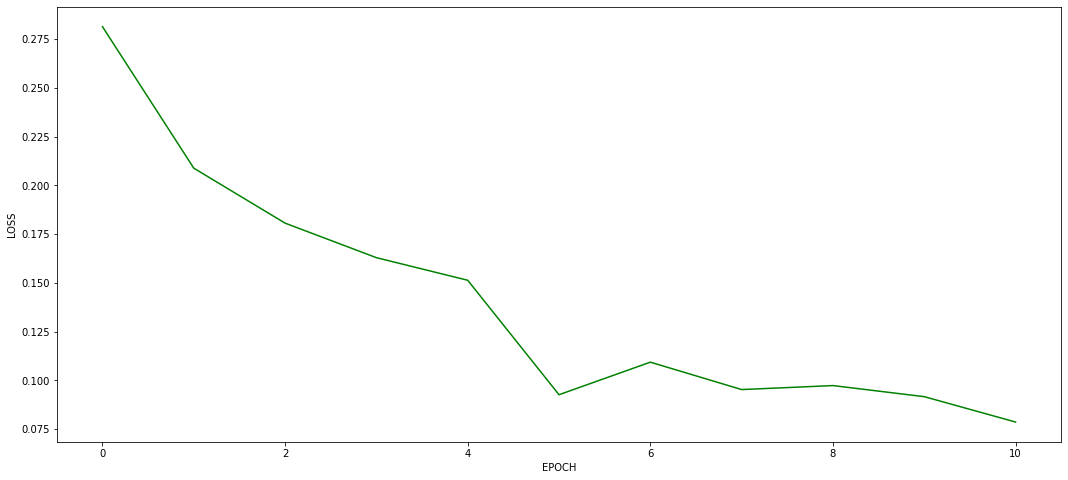

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))
plt.plot(hist['epoch'],hist['loss'], color= 'green')
# plt.plot(loss, color='red')
# plt.title("Close price of stocks sold")
plt.xlabel("EPOCH")
plt.ylabel("LOSS")
plt.show()


In [ ]:
pred_list = []
n_input=train_y.shape[0]
batch = train[-n_input:].reshape((1, n_input, n_features))
for i in range(n_input):   
  pred_list.append(model.predict(batch)[0]) 
  batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

NameError: ignored

In [ ]:
pred_list[1:]

[]

In [ ]:
model.predict(generator)

In [ ]:
add_dates = [df2.index[-1] + DateOffset(days=x) for x in range(0,n_input+1) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=df2.columns)

df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index, columns=['Prediction'])
# df_predict=df_predict[::-1]
df_proj = pd.concat([df2,df_predict], axis=1)

df_proj.tail(12)

import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))
plt.plot(df_proj['Close'][-2000:], color= 'green')
plt.plot(df_proj['Prediction'][-2000:], color='red')
plt.title("Close price of stocks sold")
plt.xlabel("Time (latest ->oldest-> )")
plt.ylabel("Stock Opening Price")
plt.show()


# another example
*  https://github.com/Tony607/Keras_TimeseriesGenerator/blob/master/TimeseriesGenerator.ipynb

*  https://www.kaggle.com/nicapotato/multivar-lstm-ts-regression-keras?select=test.csv

In [4]:
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.offsets import DateOffset
import math
from sklearn.metrics import mean_squared_error

import keras
from keras import Sequential
from keras.layers import Dense, LSTM, Conv1D, Bidirectional, Lambda,Dropout

In [5]:
# def get_y_from_generator(gen):
#     '''
#     Get all targets y from a TimeseriesGenerator instance.
#     '''
#     y = None
#     for i in range(len(gen)):
#         batch_y = gen[i][1]
#         if y is None:
#             y = batch_y
#         else:
#             y = np.append(y, batch_y)
#     y = y.reshape((-1,1))
#     print(y.shape)
#     return y

In [6]:
# def create_data_set(_data_set, _look_back=1):
#   data_x, data_y = [], [] 
#   for i in range(len(_data_set) - _look_back - 1): 
#     a = _data_set[i:(i + _look_back), 0]
#     data_x.append(a)
#     data_y.append(_data_set[i + _look_back, 0]) 
#   return np.array(data_x), np.array(data_y)

In [7]:
# dataset_DJI = pd.read_csv('DJI_20150919-20180918.csv', usecols=[4]).values.astype('float32')
# dataset_AAPL = pd.read_csv('AAPL_20150919-20180918.csv', usecols=[4]).values.astype('float32')
# dataset_AMAZN = pd.read_csv('AMZN_20150919-20180918.csv', usecols=[4]).values.astype('float32')


# def delta_time_series(data):
#     return data[1:]- data[:-1]
# ttdata=delta_time_series(tdata)


# dataset_delta_DJI = delta_time_series(dataset_DJI)
# dataset_delta_APPL = delta_time_series(dataset_AAPL)
# dataset_delta_AMAZN = delta_time_series(dataset_AMAZN)



In [8]:
dataset_x = np.array(tdata)#np.concatenate((dataset_delta_DJI, dataset_delta_APPL, dataset_delta_AMAZN), axis = 1)
# dataset_y = dataset_delta_DJI
# normalize the dataset
scaler_multi = MinMaxScaler(feature_range=(0, 1))
scaler_multi.fit_transform(dataset_x.reshape(-1, 1))
dataset_x = scaler_multi.transform(dataset_x)
# dataset_y = scaler_multi.transform(dataset_y)
# split into train and test sets
# dataset_x
train_size = int(len(dataset_x) * 0.67)
test_size = len(dataset_x) - train_size
train_x, test_x = dataset_x[0:train_size,:], dataset_x[train_size:len(dataset_x),:]
# train_y, test_y = dataset_y[0:train_size,:], dataset_y[train_size:len(dataset_y),:]

In [9]:
# dataset_xx=pd.DataFrame(dataset_x)
# dataset_yy=pd.DataFrame(0,index=tdata.index[0:5],columns=tdata.columns)
# dataset_xx.append(dataset_yy)
n_input=6
tdata=tdata[::-1]
add_dates = [tdata.index[-1] + DateOffset(years=x) for x in range(0,n_input+1) ]
future_dates = pd.DataFrame(0,index=add_dates[1:],columns=tdata.columns)

t2data=tdata.append(future_dates)
tdata=tdata[::-1]
t2data=t2data[::-1]
t2data=np.array(t2data)

scaler_multi = MinMaxScaler(feature_range=(0, 1))
scaler_multi.fit_transform(t2data.reshape(-1, 1))
t2data = scaler_multi.transform(t2data)

# tdata['Datetime'] = pd.to_datetime('19'+(ALL.columns.astype(str)) + ' ' +'10:00:00 ')
# tdata = tdata.set_index('Datetime')
# # ALL.iloc[1,:].to_list()#.dropna(how='any')
# tdata=tdata.interpolate(method='time')

In [10]:
# look_back = 6
# train_data_gen = TimeseriesGenerator(train_x, train_x,
#                                length=look_back, sampling_rate=1,stride=1,
#                                batch_size=6)
# test_data_gen = TimeseriesGenerator(test_x, test_x,
#                                length=look_back, sampling_rate=1,stride=1,
#                                batch_size=1)

# pred_data_gen = TimeseriesGenerator(t2data[::-1], t2data[::-1],
#                                length=look_back, sampling_rate=1,stride=1,
#                                batch_size=1)


train = t2data[::-1]
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
n_input = 5
n_features = t2data.data.shape[1]
generator = TimeseriesGenerator(train,train,sampling_rate=1, length=n_input, batch_size=6)

# train_x=train[0:2999]
# train_y=train[3000:5999]
train_x=train[:-12]
train_y=train[-12:-6]

training_sequence = TimeseriesGenerator(train_x, train_x,sampling_rate=1, length=n_input, batch_size=6)
validation_sequence = TimeseriesGenerator(train_y, train_y,sampling_rate=1, stride=30, length=n_input, batch_size=6)

# look_back = 1 
# train_x, train_y = create_data_set(train, look_back) 
# # test_x, test_y = create_data_set(test, look_back) 
# train_x = np.reshape(train_x,
#                         (train_x.shape[0], 1, train_x.shape[1])) 
# # test_x = np.reshape(test_x, 
# #                        (test_x.shape[0], 1, test_x.shape[1]))


In [11]:
model = Sequential()
model.add(LSTM(256, input_shape=[n_input, n_features],return_sequences=True))
model.add(Bidirectional(LSTM(128,activation='relu',return_sequences=True))),
model.add(Dropout(0.15))
model.add((LSTM(32,activation='relu'))),
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam',metrics=['mse','accuracy'])
print(model.summary())

# model_lstm = Sequential()
# model_lstm.add(LSTM(16, input_shape=(look_back,train_x.shape[1]),return_sequences=True))
# model_lstm.add(Dropout(0.5))
# model_lstm.add(LSTM(32))
# model_lstm.add(Dropout(0.5))
# model_lstm.add(Dense(1))
# model_lstm.compile(optimizer="adam", loss='mse', metrics=["mse"])
# print(model_lstm.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 256)            33882112  
_________________________________________________________________
bidirectional (Bidirectional (None, 5, 256)            394240    
_________________________________________________________________
dropout (Dropout)            (None, 5, 256)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                36992     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 34,313,377
Trainable params: 34,313,377
Non-trainable params: 0
_________________________________________________________________
None


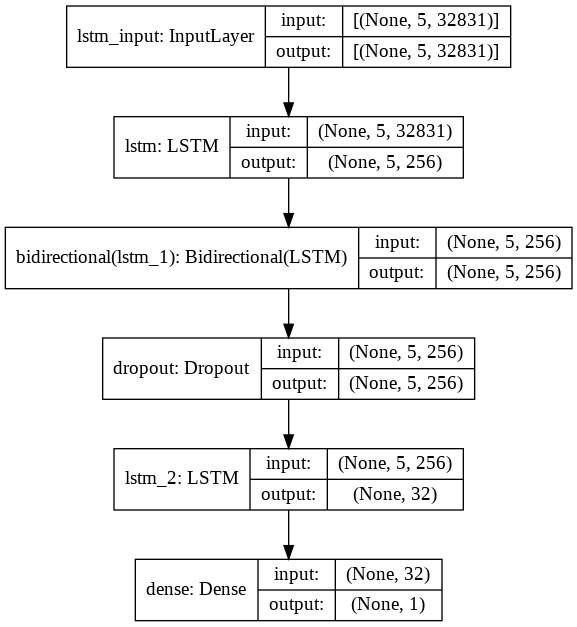

In [12]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

In [13]:
from keras.callbacks import EarlyStopping, LearningRateScheduler,ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20)),
    EarlyStopping(patience=5, verbose=1),#monitor='loss'),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=False)
]

In [14]:
# history = model.fit_generator(pred_data_gen, epochs=100)#.history

history =model.fit(training_sequence, epochs=100, callbacks=callbacks,validation_data=validation_sequence)


Epoch 1/100
5/5 [==============================] - 12s 286ms/step - loss: 0.4817 - mse: 0.4817 - accuracy: 0.0000e+00 - val_loss: 0.3486 - val_mse: 0.3486 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.34857, saving model to model.h5
Epoch 2/100
5/5 [==============================] - 0s 66ms/step - loss: 0.3010 - mse: 0.3010 - accuracy: 0.0000e+00 - val_loss: 0.2024 - val_mse: 0.2024 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 0.34857 to 0.20238, saving model to model.h5
Epoch 3/100
5/5 [==============================] - 0s 68ms/step - loss: 0.1743 - mse: 0.1743 - accuracy: 0.0040 - val_loss: 0.0951 - val_mse: 0.0951 - val_accuracy: 0.0691

Epoch 00003: val_loss improved from 0.20238 to 0.09514, saving model to model.h5
Epoch 4/100
5/5 [==============================] - 0s 71ms/step - loss: 0.0685 - mse: 0.0685 - accuracy: 0.0143 - val_loss: 0.0328 - val_mse: 0.0328 - val_accuracy: 0.0691

Epoch 00004: val_loss improved from 0.09514 to 0.03

In [17]:
model.save('drive/MyDrive/ltcopd_lstm_model.h')

INFO:tensorflow:Assets written to: drive/MyDrive/ltcopd_lstm_model.h/assets


INFO:tensorflow:Assets written to: drive/MyDrive/ltcopd_lstm_model.h/assets


In [18]:
from keras.models import load_model
model = load_model('drive/MyDrive/ltcopd_lstm_model.h')

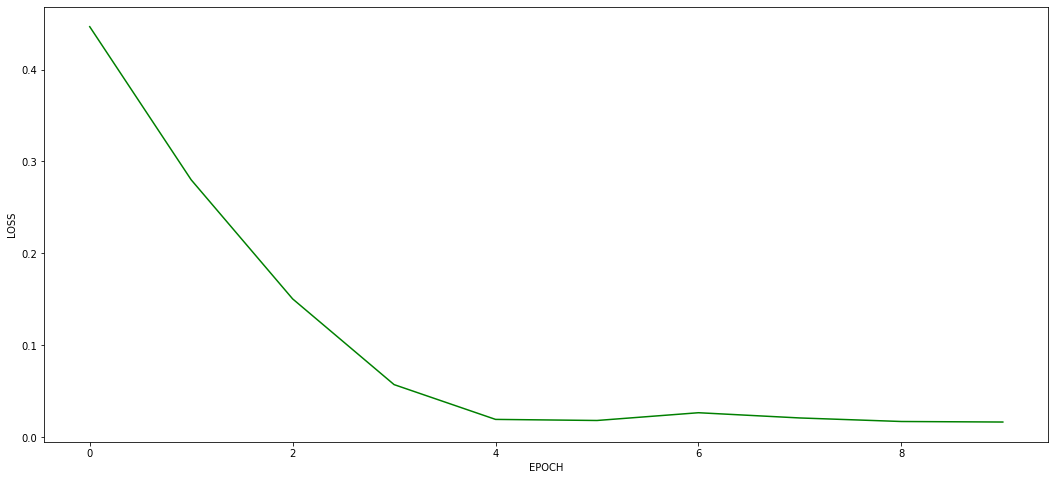

In [15]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))
plt.plot(hist['epoch'],hist['loss'], color= 'green')
# plt.plot(loss, color='red')
# plt.title("Close price of stocks sold")
plt.xlabel("EPOCH")
plt.ylabel("LOSS")
plt.show()


In [38]:
t2data=t2data[::-1]
train = t2data[:-30]
# t2data=t2data[::-1]
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)

pred_list = []
batch = train[-n_input:].reshape((1, n_input, t2data.shape[1]))
# batch=batch.T
for i in range(n_input):   
  pred_list.append(model.predict(batch.T))#[0]) 
  batch = np.append(batch[0,1:,:],pred_list[i].T,axis=0)
  # print([batch.shape,pred_list[i].T.shape])
  # batch=batch.T
  batch = np.expand_dims(batch, 0)
  print([i,batch.shape])

[0, (1, 5, 32831)]
[1, (1, 5, 32831)]
[2, (1, 5, 32831)]
[3, (1, 5, 32831)]
[4, (1, 5, 32831)]


In [39]:
pred_list=scaler.inverse_transform(np.squeeze(pred_list))
# pred_list = []
# batch = train[-n_input:].reshape((1, n_input, t2data.shape[1]))
# pred_list.append(model.predict(batch.T))
pred_list=(np.squeeze(pred_list))
pred_list=pd.DataFrame(pred_list)
pred_list

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,32791,32792,32793,32794,32795,32796,32797,32798,32799,32800,32801,32802,32803,32804,32805,32806,32807,32808,32809,32810,32811,32812,32813,32814,32815,32816,32817,32818,32819,32820,32821,32822,32823,32824,32825,32826,32827,32828,32829,32830
0,0.001292,0.000975,0.000292,0.000286,0.001162,0.000706,0.000447,0.000541,0.000288,0.000262,0.001093,0.000547,0.001026,0.000412,0.000772,0.000291,0.000471,0.000879,0.000337,0.000643,0.000673,0.000860,0.000863,0.000472,0.000488,0.000317,0.000375,0.000466,0.000731,0.000907,0.000764,0.000538,0.000668,0.000277,0.000808,0.000302,0.000785,0.000343,0.000963,0.000306,...,0.000303,0.000470,0.000261,0.000276,0.000259,0.001115,0.000534,0.000299,0.000318,0.000267,0.000762,0.000292,0.000243,0.000293,0.000310,0.000310,0.000272,0.000277,0.000595,0.000324,0.000259,0.000266,0.000283,0.000288,0.000279,0.000270,0.000383,0.000294,0.000370,0.000267,0.000346,0.000379,0.000315,0.000287,0.000377,0.000351,0.000264,0.000338,0.000292,0.000282
1,0.001158,0.000879,0.000267,0.000265,0.001044,0.000635,0.000413,0.000508,0.000275,0.000240,0.000980,0.000500,0.000919,0.000370,0.000697,0.000269,0.000453,0.000796,0.000312,0.000583,0.000618,0.000774,0.000793,0.000439,0.000446,0.000291,0.000350,0.000424,0.000662,0.000814,0.000714,0.000488,0.000613,0.000254,0.000726,0.000276,0.000713,0.000313,0.000867,0.000282,...,0.000283,0.000439,0.000240,0.000253,0.000235,0.001004,0.000523,0.000282,0.000290,0.000243,0.000701,0.000264,0.000222,0.000268,0.000287,0.000285,0.000250,0.000252,0.000552,0.000299,0.000234,0.000245,0.000260,0.000265,0.000254,0.000247,0.000350,0.000267,0.000338,0.000245,0.000322,0.000351,0.000288,0.000268,0.000354,0.000322,0.000242,0.000311,0.000268,0.000257
2,0.001056,0.000807,0.000248,0.000249,0.000964,0.000589,0.000396,0.000487,0.000270,0.000227,0.000902,0.000464,0.000841,0.000344,0.000639,0.000255,0.000450,0.000744,0.000293,0.000541,0.000583,0.000717,0.000745,0.000419,0.000418,0.000270,0.000339,0.000398,0.000614,0.000745,0.000688,0.000449,0.000585,0.000239,0.000670,0.000256,0.000665,0.000291,0.000804,0.000271,...,0.000268,0.000422,0.000225,0.000235,0.000220,0.000926,0.000513,0.000268,0.000270,0.000226,0.000656,0.000249,0.000208,0.000248,0.000272,0.000274,0.000238,0.000233,0.000525,0.000282,0.000216,0.000230,0.000243,0.000247,0.000240,0.000230,0.000331,0.000253,0.000318,0.000230,0.000305,0.000335,0.000272,0.000258,0.000336,0.000301,0.000229,0.000292,0.000254,0.000240
3,0.001051,0.000809,0.000250,0.000253,0.000966,0.000595,0.000411,0.000505,0.000282,0.000234,0.000904,0.000463,0.000838,0.000349,0.000638,0.000259,0.000460,0.000755,0.000297,0.000543,0.000594,0.000721,0.000753,0.000431,0.000425,0.000272,0.000355,0.000406,0.000620,0.000745,0.000707,0.000450,0.000604,0.000243,0.000671,0.000258,0.000673,0.000293,0.000809,0.000279,...,0.000273,0.000444,0.000229,0.000239,0.000225,0.000927,0.000527,0.000271,0.000271,0.000229,0.000661,0.000254,0.000210,0.000251,0.000278,0.000283,0.000245,0.000234,0.000537,0.000288,0.000217,0.000232,0.000245,0.000250,0.000247,0.000231,0.000341,0.000264,0.000327,0.000235,0.000312,0.000349,0.000279,0.000268,0.000343,0.000304,0.000233,0.000298,0.000259,0.000245
4,0.001138,0.000877,0.000272,0.000275,0.001049,0.000646,0.000450,0.000557,0.000307,0.000254,0.000981,0.000501,0.000908,0.000380,0.000691,0.000282,0.000490,0.000822,0.000322,0.000589,0.000648,0.000783,0.000817,0.000470,0.000463,0.000295,0.000387,0.000441,0.000674,0.000807,0.000766,0.000488,0.000665,0.000264,0.000728,0.000279,0.000732,0.000318,0.000879,0.000304,...,0.000297,0.000477,0.000249,0.000259,0.000245,0.001004,0.000583,0.000294,0.000294,0.000249,0.000718,0.000278,0.000228,0.000272,0.000301,0.000308,0.000265,0.000253,0.000581,0.000313,0.000235,0.000251,0.000266,0.000271,0.000268,0.000250,0.000372,0.000286,0.000352,0.000255,0.000338,0.000377,0.000302,0.000291,0.000372,0.000329,0.000253,0.000324,0.000281,0.000267


In [55]:
pred=pd.DataFrame(t2data[::-1])[:-6]
pred=pred.append(pred_list*1000)
pred=pred.reset_index()
del pred['index']

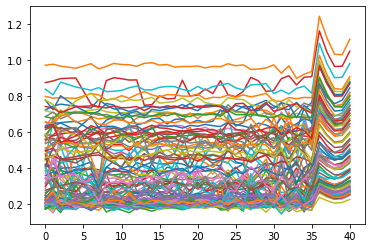

In [58]:
w=plt.plot(pred.iloc[:,1:100])


## new analysis

In [ ]:
model_lstm.evaluate_generator(test_data_gen)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.04990417882800102, 0.04990417882800102]

In [ ]:
trainPredict = model.predict_generator(train_data_gen)
testPredict = model.predict_generator(test_data_gen)
predPredict = model.predict_generator(pred_data_gen)

[trainPredict.shape,
testPredict.shape,
 predPredict.shape]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[(18, 1), (6, 1), (36, 1)]

In [ ]:
trainY = get_y_from_generator(train_data_gen)
testY = get_y_from_generator(test_data_gen)
predY = get_y_from_generator(pred_data_gen)

trainY = scaler_multi.inverse_transform(trainY)
testY = scaler_multi.inverse_transform(testY)
predY = scaler_multi.inverse_transform(predY)



(590958, 1)
(196986, 1)
(1181916, 1)


In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:, 0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset_x)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# Delta + previous close
trainPredictPlot = trainPredictPlot #+ dataset_DJI[1:]


# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset_x)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset_x), :] = testPredict

# Delta + previous close
testPredictPlot = testPredictPlot #+ dataset_DJI[1:]


# predPredictPlot = np.empty_like(dataset_x)
# predPredictPlot[:, :] = np.nan
# predPredictPlot[look_back:len(predPredict)+look_back, :] = predPredict
# # Delta + previous close
# predPredictPlot = predPredictPlot #+ dataset_DJI[1:]


# plot baseline and predictions
# plt.plot(dataset_x)# + dataset_DJI[1:])
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.show()

In [ ]:
plt.plot(dataset_x[:,1:10])# + dataset_DJI[1:])
plt.plot(predPredict[:,1:10])
plt.plot(testPredictPlot[:,1:10])
plt.show()

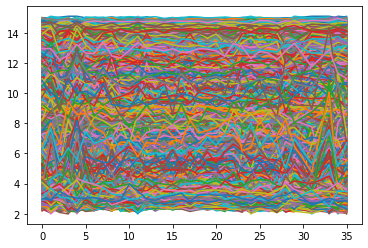

In [ ]:
predYY=predY.reshape(36,32831)
plt.plot(predYY)# + dataset_DJI[1:])
plt.show()